In [89]:
%reset
#https://thinkinfi.com/clip-raster-with-a-shape-file-in-python/ 
#https://matplotlib.org/cmocean/

Nothing done.


In [90]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
#import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd

In [91]:

import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

In [92]:

import fiona
import earthpy as et
import earthpy.plot as ep
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal
import numpy as np
import rasterio
import richdem as rd
import seaborn as sns

In [93]:
import os
import cmocean
ROOT_DIR = os.path.abspath(os.curdir)

In [94]:
path_dem_snoho = ROOT_DIR + '/Data/Raw/demf_snoho.tif'
#path_dem_snoho

In [95]:
#set relative path
#path_dem = '/Users/carina/Desktop/code/Snow_SCL/demf_snoho.tif'
with rio.open(path_dem_snoho) as dem_src:
    dtm_pre_arr = dem_src.read(1, masked = True)

In [96]:
snoho_cmap = cmocean.tools.crop(cmocean.cm.topo, 0, dtm_pre_arr.max(), dtm_pre_arr.min())

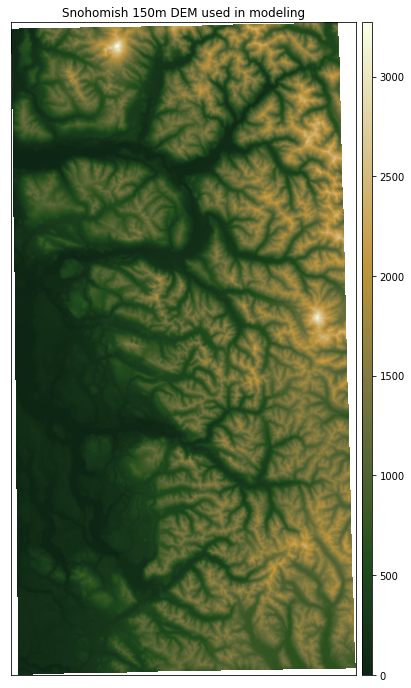

In [97]:
#plot dem

ep.plot_bands(dtm_pre_arr,
              title="Snohomish 150m DEM used in modeling",
              cmap = snoho_cmap)

plt.show()

In [98]:
# Read shape file (created by Las Bound) using geopandas
shape_file = gpd.read_file(ROOT_DIR + "/Data/Raw/Tolt_boundary/Tolt_boundary.shp")

# Read imagery file downloaded from national map
#imagery = rasterio.open("/Users/carina/Desktop/code/Snow_SCL/demf_snoho.tif")

# Plot imagery
#show(imagery)

In [99]:
shape_file

,Name,geometry
0,WA20200921194516175000,"POLYGON ((-121.85709 47.76639, -121.85698 47.7..."


In [100]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', shape_file.crs)

print('Imagery file Projection: ', dem_src.crs)


Shape file Projection:  epsg:4326
Imagery file Projection:  EPSG:26910


In [101]:
# Transform projection of imagery to specific coordinate system

# Specify output projection system
dst_crs = 'EPSG:4326'

# Input imagery file name before transformation
input_imagery_file = path_dem_snoho
# Save output imagery file name after transformation
transformed_imagery_file = ROOT_DIR + '/Data/Processed/imagery_trans.tif'

with rasterio.open(input_imagery_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rasterio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rasterio.band(imagery, i),
                destination=rasterio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [102]:
# Plot again after transformation. You can observe axis value have changed
tr_imagery = rasterio.open(ROOT_DIR + '/Data/Processed/imagery_trans.tif')
# Plot trasformed imagery
#show(tr_imagery)

# Check coordinate reference system of transformed imagery, it's changed or not?
print('Transformed Imagery file Projection: ', tr_imagery.crs)
# tr_imagery.crs

Transformed Imagery file Projection:  EPSG:4326


In [103]:
# Read Shape file
with fiona.open(ROOT_DIR + "/Data/Raw/Tolt_boundary/Tolt_boundary.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    
# read imagery file
with rasterio.open(ROOT_DIR + '/Data/Processed/imagery_trans.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop = True)
    out_meta = src.meta

In [104]:
# Save clipped imagery
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(ROOT_DIR + '/Data/Final/dem_tolt_tran_clip.tif', "w", **out_meta) as dest:
   dest.write(out_image)

In [105]:
#tolt_dem = rd.LoadGDAL("/Users/carina/Desktop/code/Snow_SCL/dem_tolt_tran_clip.tif")

In [106]:
with rio.open(ROOT_DIR + '/Data/dem_tolt_tran_clip.tif') as dem_tolt_:
    dem_tolt_ = dem_tolt_.read(1, masked = True)

ep.plot_bands(dem_tolt_,
              title="Tolt 150m DEM used in modeling",
              cmap="Greys")

plt.show()    

RasterioIOError: /Users/nicoleta/Desktop/code/Snow_SCL/Data/dem_tolt_tran_clip.tif: No such file or directory

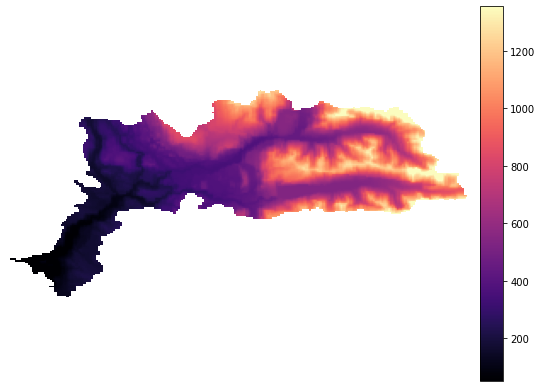

In [107]:
#example use richdem
dem_test     = rd.LoadGDAL(ROOT_DIR + '/Data/Final/dem_tolt_tran_clip.tif')
rd.rdShow(dem_test, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()


A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000613166==================== ] (99% - 0.0s - 1 threads)


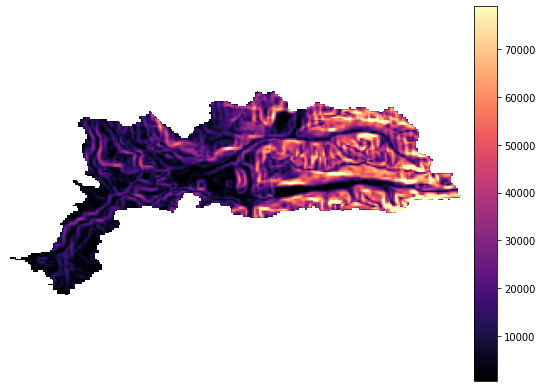

In [108]:
slope = rd.TerrainAttribute(dem_test, attrib = 'slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()


A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00114608===================== ] (99% - 0.0s - 1 threads)


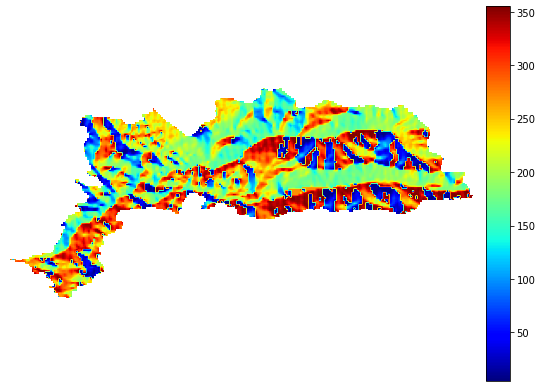

In [109]:
aspect = rd.TerrainAttribute(dem_test, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [110]:
#calculate slope and aspect with gdal 

def calculate_slope(DEM):
    gdal.DEMProcessing('slope.tif', DEM, 'slope')
    with rasterio.open('slope.tif') as dataset:
        slope=dataset.read(1, masked = True)
    return slope

def calculate_aspect(DEM):
    gdal.DEMProcessing('aspect.tif', DEM, 'aspect')
    with rasterio.open('aspect.tif') as dataset:
        aspect=dataset.read(1, masked = True)
    return aspect

In [111]:
slope_ = calculate_slope(ROOT_DIR + '/Data/Final/dem_tolt_tran_clip.tif')
aspect_ = calculate_aspect(ROOT_DIR + '/Data/Final/dem_tolt_tran_clip.tif')

print(type(slope_))
print(slope_.dtype)
print(slope_.shape)

<class 'numpy.ma.core.MaskedArray'>
float32
(125, 272)


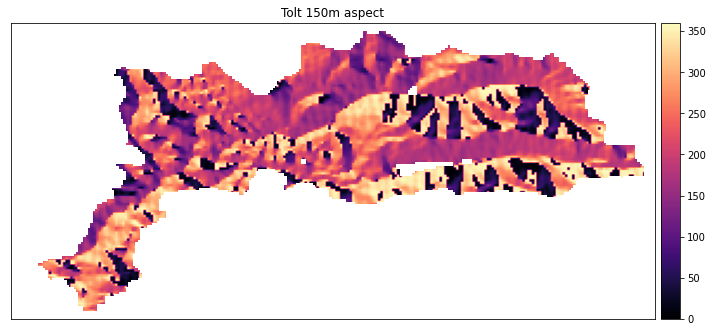

In [112]:
ep.plot_bands(aspect_,
              title="Tolt 150m aspect",
              cmap="magma")

plt.show()  